# Assignment 3 Part 2: Fashion Classifier Model
## By Alessandro Allegranzi 5/29/2024

## Import Statements

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from functools import partial

from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg

# Constants for where to save the models
FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/models"

## Donwload the Fashion MNIST Dataset.

The dataset is "60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images."  https://keras.io/api/datasets/fashion_mnist/

In [2]:
# https://keras.io/api/datasets/fashion_mnist/
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1 like we did in assignment 3 part 1.
train_images, test_images = train_images / 255.0, test_images / 255.0

4422102/4422102 [==============================] - 0s 0us/step


## Visualizing Some of the Data

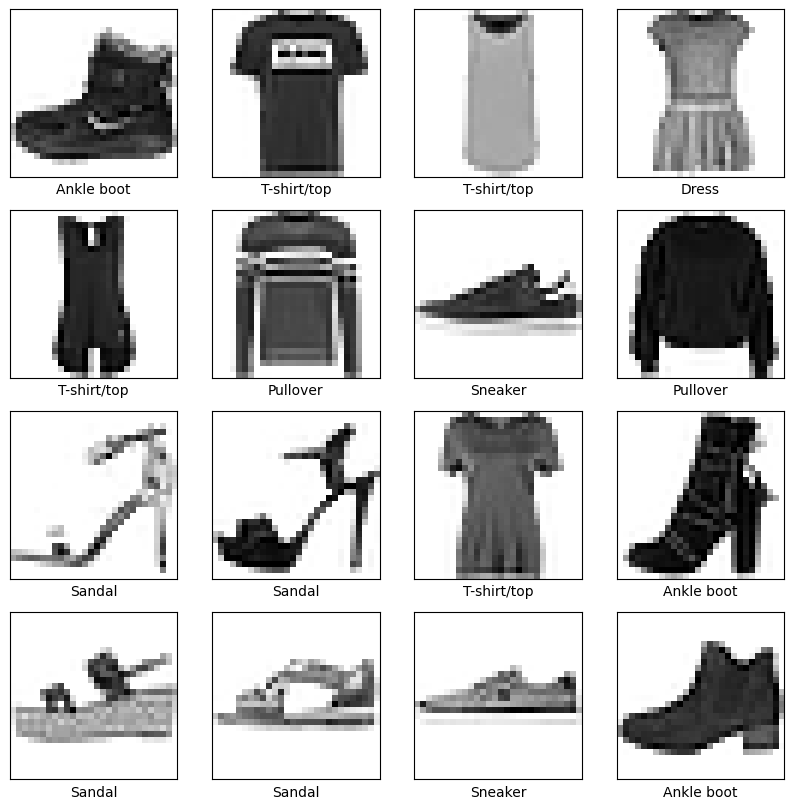

In [3]:
# Class names are listed in the Keras docs.
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Defining the Model.
It starts with a convolutional layer with 32 filters of size 5x5, followed by a batch normalization layer and a max pooling layer. This pattern of a convolutional layer, batch normalization, and max pooling is repeated three more times, with the number of filters in the convolutional layers increasing to 64, 64, and 128 respectively. After the convolutional layers, the model has another convolutional layer with 128 filters, followed by a flatten layer to reshape the 3D outputs to 1D. Then, there are two dense (fully connected) layers with 64 and 32 neurons respectively, each followed by batch normalization and a dropout layer with a rate of 0.5 for regularization. The model ends with a dense layer with 10 neurons and a softmax activation function because we have 10 classes we are training to identify. The 'relu' activation function is used in all convolutional and dense layers except the last one, and the 'he_normal' initializer is used to initialize the weights.

In [4]:
## Convolutional Model definition

# Default convolutional layer settings modeled after ch.14 in the Geron text.
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding='same',
                        activation='relu', kernel_initializer='he_normal')

model = tf.keras.Sequential([
  # Setting up he main pattern of convolutional layer + batch normalization
  # + pooling. Starting with a larger kernel size in the first layer.
  DefaultConv2D(filters=32, kernel_size=5, input_shape=(28, 28, 1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  DefaultConv2D(filters=64),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  DefaultConv2D(filters=64),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  DefaultConv2D(filters=128),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  DefaultConv2D(filters=128),
  # Dense layers. Also adding in Dropout for more efficient training.
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu',
                        kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu',
                        kernel_initializer='he_normal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax')
])


## Model description
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                        

## Visualizing the Model architecture

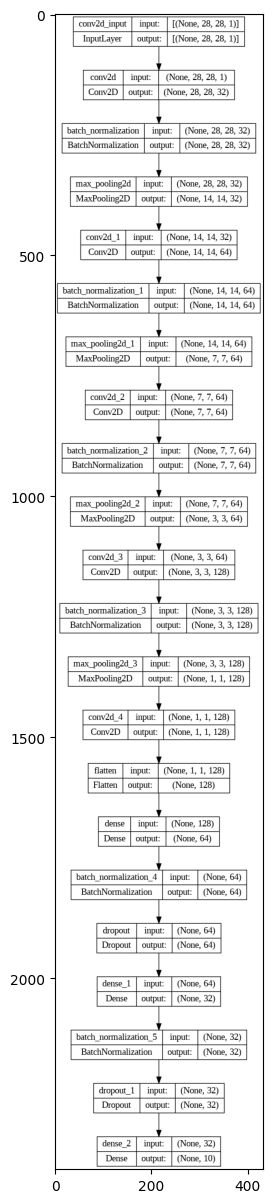

In [6]:
file_name = FILE_PATH + '/model_layers.png'
# Generate the plot
plot_model(model, to_file=file_name, show_shapes=True, show_layer_names=True)

# Show the plot here
img = mpimg.imread(file_name)
plt.figure(figsize=(30,15))
imgplot = plt.imshow(img)
plt.show()

## Compile and train the model

In [18]:
# Compiling with RMS prop as the optimization function.
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Adding 2 callback functions to save the most effective model and to short circuit
# the training if epochs stop improving the model after 2 epochs.
# https://keras.io/api/callbacks/early_stopping/
# https://keras.io/api/callbacks/model_checkpoint/
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model_checkpoint = ModelCheckpoint(FILE_PATH, monitor='val_loss', save_best_only=True)

history = model.fit(train_images, train_labels, epochs=6,
                    validation_data=(test_images, test_labels), callbacks=[early_stopping, model_checkpoint])

Epoch 1/6
1875/1875 [==============================] - 157s 83ms/step - loss: 0.7116 - accuracy: 0.7696 - val_loss: 0.4130 - val_accuracy: 0.8590
Epoch 2/6
1875/1875 [==============================] - 158s 84ms/step - loss: 0.4193 - accuracy: 0.8735 - val_loss: 0.3266 - val_accuracy: 0.8911
Epoch 3/6
1875/1875 [==============================] - 150s 80ms/step - loss: 0.3546 - accuracy: 0.8942 - val_loss: 0.3469 - val_accuracy: 0.8947
Epoch 4/6
1875/1875 [==============================] - 161s 86ms/step - loss: 0.3157 - accuracy: 0.9069 - val_loss: 0.2778 - val_accuracy: 0.9101
Epoch 5/6
1875/1875 [==============================] - 158s 84ms/step - loss: 0.2863 - accuracy: 0.9164 - val_loss: 0.2797 - val_accuracy: 0.9123
Epoch 6/6
1875/1875 [==============================] - 157s 84ms/step - loss: 0.2640 - accuracy: 0.9223 - val_loss: 0.2860 - val_accuracy: 0.9132


## Evaluate the Model

313/313 - 6s - loss: 0.2860 - accuracy: 0.9132 - 6s/epoch - 19ms/step
model accuracy:  0.9132000207901001


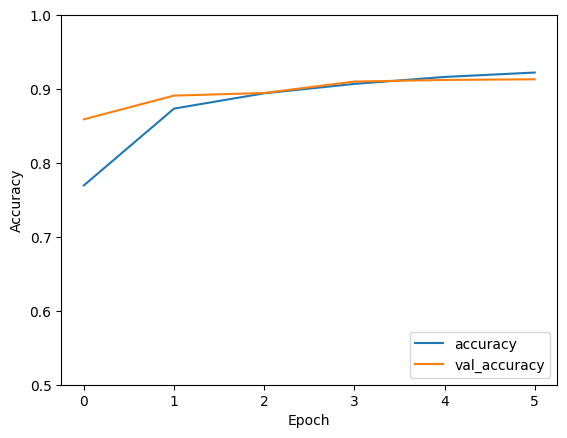

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print("model accuracy: ", test_acc)

In [22]:
# Testing out the model.
# Preprocess the image
img_tensor = tf.keras.preprocessing.image.img_to_array(test_images[1])
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Classify the image
predictions = model.predict(img_tensor)
predicted_class = np.argmax(predictions)

print(f'The model predicts that the image belongs to class {class_names[predicted_class]}.')
print(f'The unformatted result with probability for all classes {predictions}')

1/1 [==============================] - 0s 26ms/step
The model predicts that the image belongs to class Sneaker.
The unformatted result with probability for all classes [[1.06928665e-02 9.08407310e-06 1.35429460e-03 3.30683921e-04
  9.03731387e-04 9.10533301e-04 1.55516504e-03 9.73287463e-01
  9.50120389e-03 1.45498291e-03]]
